<h2>First of all: Segmented CTE</h2>
How do we switch over from one segment (provided by A*) to the next while calculating Cross-Track-Error (CTE) in an attempt to apply PID to that.

Heuristics:  [[9, 8, 7, 6, 5, 4], [8, 7, 6, 5, 4, 3], [7, 6, 5, 4, 3, 2], [6, 5, 4, 3, 2, 1], [5, 4, 3, 2, 1, 0]]
A* path:  [[0, 0], [1, 0], [2, 0], [3, 0], [3, 1], [3, 2], [2, 2], [1, 2], [0, 2], [0, 3], [0, 4], [0, 5], [1, 5], [2, 5], [2, 4], [3, 4], [4, 4], [4, 5]]
Smoothed path:  [[0, 0], [1.1796490799484765, -0.027097786688960502], [2.229427696296309, 0.06528337202664698], [2.948424765953323, 0.38736163568256754], [3.136931576835533, 0.9422917128646766], [2.7888070895155517, 1.4794555343809026], [1.9822275370573637, 1.8063145881939435], [1.0185563224616838, 2.0614511340653325], [0.22164465051272253, 2.4838017711338676], [-0.17274735276941902, 3.2117262927684425], [-0.17285116861097255, 4.049063639575604], [0.1874922355330803, 4.685736111693432], [0.8609218037591869, 4.875012057930311], [1.626043544532527, 4.672826975872756], [2.3255365638759256, 4.299861268672558], [3.0179440913437166, 4.161534664331901], [3.599737992766264, 4.4112773969096075], [4, 5]]
[True, 0, 149]


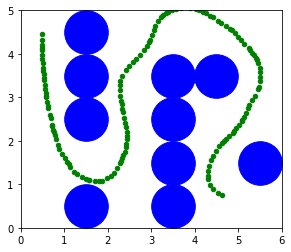

In [43]:
# -----------
# User Instructions
#
# Familiarize yourself with the code below. Most of it
# reproduces results that you have obtained at some
# point in this class. Once you understand the code,
# write a function, cte, in the run class that
# computes the crosstrack
# error for the case of a segmented path. You will
# need to include the equations shown in the video.
#
 
from math import *
import random


# don't change the noise paameters

steering_noise    = 0.1
distance_noise    = 0.03
measurement_noise = 0.3


class plan:

    # --------
    # init: 
    #    creates an empty plan
    #

    def __init__(self, grid, init, goal, cost = 1):
        self.cost = cost
        self.grid = grid
        self.init = init
        self.goal = goal
        self.make_heuristic(grid, goal, self.cost)
        self.path = []
        self.spath = []

    # --------
    #
    # make heuristic function for a grid
        
    def make_heuristic(self, grid, goal, cost):
        self.heuristic = [[0 for row in range(len(grid[0]))] 
                          for col in range(len(grid))]
        for i in range(len(self.grid)):    
            for j in range(len(self.grid[0])):
                self.heuristic[i][j] = abs(i - self.goal[0]) + \
                    abs(j - self.goal[1])



    # ------------------------------------------------
    # 
    # A* for searching a path to the goal
    #
    #

    def astar(self):


        if self.heuristic == []:
            raise Exception(ValueError, "Heuristic must be defined to run A*")

        # internal motion parameters
        delta = [[-1,  0], # go up
                 [ 0,  -1], # go left
                 [ 1,  0], # go down
                 [ 0,  1]] # do right


        # open list elements are of the type: [f, g, h, x, y]

        closed = [[0 for row in range(len(self.grid[0]))] 
                  for col in range(len(self.grid))]
        action = [[0 for row in range(len(self.grid[0]))] 
                  for col in range(len(self.grid))]

        closed[self.init[0]][self.init[1]] = 1


        x = self.init[0]
        y = self.init[1]
        h = self.heuristic[x][y]
        g = 0
        f = g + h

        open = [[f, g, h, x, y]]

        found  = False # flag that is set when search complete
        resign = False # flag set if we can't find expand
        count  = 0


        while not found and not resign:

            # check if we still have elements on the open list
            if len(open) == 0:
                resign = True
                print('###### Search terminated without success')
                
            else:
                # remove node from list
                open.sort()
                open.reverse()
                next = open.pop()
                x = next[3]
                y = next[4]
                g = next[1]

            # check if we are done

            if x == goal[0] and y == goal[1]:
                found = True
                # print '###### A* search successful'

            else:
                # expand winning element and add to new open list
                for i in range(len(delta)):
                    x2 = x + delta[i][0]
                    y2 = y + delta[i][1]
                    if x2 >= 0 and x2 < len(self.grid) and y2 >= 0 \
                            and y2 < len(self.grid[0]):
                        if closed[x2][y2] == 0 and self.grid[x2][y2] == 0:
                            g2 = g + self.cost
                            h2 = self.heuristic[x2][y2]
                            f2 = g2 + h2
                            open.append([f2, g2, h2, x2, y2])
                            closed[x2][y2] = 1
                            action[x2][y2] = i

            count += 1

        # extract the path



        invpath = []
        x = self.goal[0]
        y = self.goal[1]
        invpath.append([x, y])
        while x != self.init[0] or y != self.init[1]:
            x2 = x - delta[action[x][y]][0]
            y2 = y - delta[action[x][y]][1]
            x = x2
            y = y2
            invpath.append([x, y])

        self.path = []
        for i in range(len(invpath)):
            self.path.append(invpath[len(invpath) - 1 - i])




    # ------------------------------------------------
    # 
    # this is the smoothing function
    #

  


    def smooth(self, weight_data = 0.1, weight_smooth = 0.1, 
               tolerance = 0.000001):

        if self.path == []:
            raise Exception(ValueError, "Run A* first before smoothing path")

        self.spath = [[0 for row in range(len(self.path[0]))] \
                           for col in range(len(self.path))]
        for i in range(len(self.path)):
            for j in range(len(self.path[0])):
                self.spath[i][j] = self.path[i][j]

        change = tolerance
        while change >= tolerance:
            change = 0.0
            for i in range(1, len(self.path)-1):
                for j in range(len(self.path[0])):
                    aux = self.spath[i][j]
                    
                    self.spath[i][j] += weight_data * \
                        (self.path[i][j] - self.spath[i][j])
                    
                    self.spath[i][j] += weight_smooth * \
                        (self.spath[i-1][j] + self.spath[i+1][j] 
                         - (2.0 * self.spath[i][j]))
                    if i >= 2:
                        self.spath[i][j] += 0.5 * weight_smooth * \
                            (2.0 * self.spath[i-1][j] - self.spath[i-2][j] 
                             - self.spath[i][j])
                    if i <= len(self.path) - 3:
                        self.spath[i][j] += 0.5 * weight_smooth * \
                            (2.0 * self.spath[i+1][j] - self.spath[i+2][j] 
                             - self.spath[i][j])
                
            change += abs(aux - self.spath[i][j])
                






# ------------------------------------------------
# 
# this is the robot class
#

class robot:

    # --------
    # init: 
    #	creates robot and initializes location/orientation to 0, 0, 0
    #

    def __init__(self, length = 0.5):
        self.x = 0.0
        self.y = 0.0
        self.orientation = 0.0
        self.length = length
        self.steering_noise    = 0.0
        self.distance_noise    = 0.0
        self.measurement_noise = 0.0
        self.num_collisions    = 0
        self.num_steps         = 0

    # --------
    # set: 
    #	sets a robot coordinate
    #

    def set(self, new_x, new_y, new_orientation):

        self.x = float(new_x)
        self.y = float(new_y)
        self.orientation = float(new_orientation) % (2.0 * pi)


    # --------
    # set_noise: 
    #	sets the noise parameters
    #

    def set_noise(self, new_s_noise, new_d_noise, new_m_noise):
        # makes it possible to change the noise parameters
        # this is often useful in particle filters
        self.steering_noise     = float(new_s_noise)
        self.distance_noise    = float(new_d_noise)
        self.measurement_noise = float(new_m_noise)

    # --------
    # check: 
    #    checks of the robot pose collides with an obstacle, or
    # is too far outside the plane

    def check_collision(self, grid):
        for i in range(len(grid)):
            for j in range(len(grid[0])):
                if grid[i][j] == 1:
                    dist = sqrt((self.x - float(i)) ** 2 + 
                                (self.y - float(j)) ** 2)
                    if dist < 0.5:
                        self.num_collisions += 1
                        return False
        return True
        
    def check_goal(self, goal, threshold = 1.0):
        dist =  sqrt((float(goal[0]) - self.x) ** 2 + (float(goal[1]) - self.y) ** 2)
        return dist < threshold
        
    # --------
    # move: 
    #    steering = front wheel steering angle, limited by max_steering_angle
    #    distance = total distance driven, most be non-negative

    def move(self, grid, steering, distance, 
             tolerance = 0.001, max_steering_angle = pi / 4.0):

        if steering > max_steering_angle:
            steering = max_steering_angle
        if steering < -max_steering_angle:
            steering = -max_steering_angle
        if distance < 0.0:
            distance = 0.0


        # make a new copy
        res = robot()
        res.length            = self.length
        res.steering_noise    = self.steering_noise
        res.distance_noise    = self.distance_noise
        res.measurement_noise = self.measurement_noise
        res.num_collisions    = self.num_collisions
        res.num_steps         = self.num_steps + 1

        # apply noise
        steering2 = random.gauss(steering, self.steering_noise)
        distance2 = random.gauss(distance, self.distance_noise)


        # Execute motion
        turn = tan(steering2) * distance2 / res.length

        if abs(turn) < tolerance:

            # approximate by straight line motion

            res.x = self.x + (distance2 * cos(self.orientation))
            res.y = self.y + (distance2 * sin(self.orientation))
            res.orientation = (self.orientation + turn) % (2.0 * pi)

        else:

            # approximate bicycle model for motion

            radius = distance2 / turn
            cx = self.x - (sin(self.orientation) * radius)
            cy = self.y + (cos(self.orientation) * radius)
            res.orientation = (self.orientation + turn) % (2.0 * pi)
            res.x = cx + (sin(res.orientation) * radius)
            res.y = cy - (cos(res.orientation) * radius)

        # check for collision
        # res.check_collision(grid)

        return res

    # --------
    # sense: 
    #    

    def sense(self):

        return [random.gauss(self.x, self.measurement_noise),
                random.gauss(self.y, self.measurement_noise)]

    # --------
    # measurement_prob
    #    computes the probability of a measurement
    # 

    def measurement_prob(self, measurement):

        # compute errors
        error_x = measurement[0] - self.x
        error_y = measurement[1] - self.y

        # calculate Gaussian
        error = exp(- (error_x ** 2) / (self.measurement_noise ** 2) / 2.0) \
            / sqrt(2.0 * pi * (self.measurement_noise ** 2))
        error *= exp(- (error_y ** 2) / (self.measurement_noise ** 2) / 2.0) \
            / sqrt(2.0 * pi * (self.measurement_noise ** 2))

        return error



    def __repr__(self):
        # return '[x=%.5f y=%.5f orient=%.5f]'  % (self.x, self.y, self.orientation)
        return '[%.5f, %.5f]'  % (self.x, self.y)






# ------------------------------------------------
# 
# this is the particle filter class
#

class particles:

    # --------
    # init: 
    #	creates particle set with given initial position
    #

    def __init__(self, x, y, theta, 
                 steering_noise, distance_noise, measurement_noise, N = 100):
        self.N = N
        self.steering_noise    = steering_noise
        self.distance_noise    = distance_noise
        self.measurement_noise = measurement_noise
        
        self.data = []
        for i in range(self.N):
            r = robot()
            r.set(x, y, theta)
            r.set_noise(steering_noise, distance_noise, measurement_noise)
            self.data.append(r)


    # --------
    #
    # extract position from a particle set
    # 
    
    def get_position(self):
        x = 0.0
        y = 0.0
        orientation = 0.0

        for i in range(self.N):
            x += self.data[i].x
            y += self.data[i].y
            # orientation is tricky because it is cyclic. By normalizing
            # around the first particle we are somewhat more robust to
            # the 0=2pi problem
            orientation += (((self.data[i].orientation
                              - self.data[0].orientation + pi) % (2.0 * pi)) 
                            + self.data[0].orientation - pi)
        return [x / self.N, y / self.N, orientation / self.N]

    # --------
    #
    # motion of the particles
    # 

    def move(self, grid, steer, speed):
        newdata = []

        for i in range(self.N):
            r = self.data[i].move(grid, steer, speed)
            newdata.append(r)
        self.data = newdata

    # --------
    #
    # sensing and resampling
    # 

    def sense(self, Z):
        w = []
        for i in range(self.N):
            w.append(self.data[i].measurement_prob(Z))

        # resampling (careful, this is using shallow copy)
        p3 = []
        index = int(random.random() * self.N)
        beta = 0.0
        mw = max(w)

        for i in range(self.N):
            beta += random.random() * 2.0 * mw
            while beta > w[index]:
                beta -= w[index]
                index = (index + 1) % self.N
            p3.append(self.data[index])
        self.data = p3

    



    

# --------
#
# run:  runs control program for the robot
#


def run(grid, goal, spath, params, printflag = False, speed = 0.1, timeout = 1000):

    myrobot = robot()
    myrobot.set(0., 0., 0.)
    myrobot.set_noise(steering_noise, distance_noise, measurement_noise)
    filter = particles(myrobot.x, myrobot.y, myrobot.orientation,
                       steering_noise, distance_noise, measurement_noise)

    cte  = 0.0
    err  = 0.0
    N    = 0

    index = 0 # index into the path
    
    while not myrobot.check_goal(goal) and N < timeout:

        diff_cte = - cte


        # ----------------------------------------
        # compute the CTE

        # start with the present robot estimate
        estimate = filter.get_position()

        ### ENTER CODE HERE
        # AE: First figure out where the robot is
        cur_robot_x = estimate[0]
        cur_robot_y = estimate[1]
        
        #print(cur_robot_x, cur_robot_y)
        
        # AE: Now figure out which segment in the spath we want to use.
        if index < len(spath) - 2: # AE: range goes to the length - 2 so that at all times we have one more point above the current one (so that we have a segment defined by two points at all times.)
            p1 = [spath[index][0], spath[index][1]] # AE: Point P1 - the beginning of segment
            p2 = [spath[index + 1][0], spath[index + 1][1]] # AE: Point P2 - the end of segment
            
            # AE: Now all the parameters for the formula in the video and notes:
            x1 = p1[0]
            y1 = p1[1]
            x2 = p2[0]
            y2 = p2[1]
            delta_x = x2 - x1
            delta_y = y2 - y1
            Rx = cur_robot_x - x1
            Ry = cur_robot_y - y1
            
            u = (Rx * delta_x + Ry * delta_y) / (delta_x ** 2 + delta_y **2)
            
            # AE: If u is greater than 1, then we need to increase the index to take next segment of path.
            if u > 1.0:
                index += 1
        
        cte = (Ry * delta_x - Rx * delta_y) / sqrt(delta_x ** 2 + delta_y ** 2)

        # ----------------------------------------


        diff_cte += cte

        steer = - params[0] * cte - params[1] * diff_cte 

        myrobot = myrobot.move(grid, steer, speed)
        filter.move(grid, steer, speed)

        Z = myrobot.sense()
        filter.sense(Z)

        if not myrobot.check_collision(grid):
            print('##### Collision ####')

        err += (cte ** 2)
        N += 1

        if printflag:
            print(myrobot, cte, index, u)

        ### PLOT THE ROBOT PATH
        plot_point(myrobot.x, myrobot.y, color = "green")
    
    return [myrobot.check_goal(goal), myrobot.num_collisions, myrobot.num_steps]


# ------------------------------------------------
# 
# this is our main routine
#

def main(grid, init, goal, steering_noise, distance_noise, measurement_noise, 
     weight_data, weight_smooth, p_gain, d_gain):

    path = plan(grid, init, goal)
    print("Heuristics: ", path.heuristic)
    path.astar()
    print("A* path: ", path.path)
    path.smooth(weight_data, weight_smooth)
    print("Smoothed path: ", path.spath)
    return run(grid, goal, path.spath, [p_gain, d_gain])


def twiddle(init_params):
    n_params   = len(init_params)
    dparams    = [1.0 for row in range(n_params)]
    params     = [0.0 for row in range(n_params)]
    K = 10

    for i in range(n_params):
        params[i] = init_params[i]


    best_error = 0.0;
    for k in range(K):
        ret = main(grid, init, goal, 
                   steering_noise, distance_noise, measurement_noise, 
                   params[0], params[1], params[2], params[3])
        if ret[0]:
            best_error += ret[1] * 100 + ret[2]
        else:
            best_error += 99999
    best_error = float(best_error) / float(k+1)
    print(best_error)

    n = 0
    while sum(dparams) > 0.0000001:
        for i in range(len(params)):
            params[i] += dparams[i]
            err = 0
            for k in range(K):
                ret = main(grid, init, goal, 
                           steering_noise, distance_noise, measurement_noise, 
                           params[0], params[1], params[2], params[3])
                if ret[0]:
                    err += ret[1] * 100 + ret[2]
                else:
                    err += 99999
            print(float(err) / float(k+1))
            if err < best_error:
                best_error = float(err) / float(k+1)
                dparams[i] *= 1.1
            else:
                params[i] -= 2.0 * dparams[i]            
                err = 0
                for k in range(K):
                    ret = main(grid, init, goal, 
                               steering_noise, distance_noise, measurement_noise, 
                               params[0], params[1], params[2], params[3])
                    if ret[0]:
                        err += ret[1] * 100 + ret[2]
                    else:
                        err += 99999
                print(float(err) / float(k+1))
                if err < best_error:
                    best_error = float(err) / float(k+1)
                    dparams[i] *= 1.1
                else:
                    params[i] += dparams[i]
                    dparams[i] *= 0.5
        n += 1
        print('Twiddle #', n, params, ' -> ', best_error)
    print(' ')
    return params



# ------------------------------------------------
# 
# input data and parameters
#


# grid format:
#   0 = navigable space
#   1 = occupied space

grid = [[0, 1, 0, 0, 0, 0],
        [0, 1, 0, 1, 1, 0],
        [0, 1, 0, 1, 0, 0],
        [0, 0, 0, 1, 0, 1],
        [0, 1, 0, 1, 0, 0]]


init = [0, 0]
goal = [len(grid)-1, len(grid[0])-1]


steering_noise    = 0.1
distance_noise    = 0.03
measurement_noise = 0.3

weight_data       = 0.1
weight_smooth     = 0.2
p_gain            = 2.0
d_gain            = 6.0


### Adding path and map plots
import matplotlib.pyplot as plt
%matplotlib inline
def plot_point(i,j,size = 20, color = 'blue'):
    plt.scatter(j+.5,len(grid)-.5-i, s=size, color = color)
plt.xlim(0,len(grid[0]))
plt.ylim(0,len(grid))
plt.gca().set_aspect('equal')
###PLOT THE GRID
for i in range(len(grid)):
    for j in range(len(grid[0])):
        if grid[i][j] == 1:
            plot_point(i,j,size = 1900)
            
print(
    main(grid, init, goal, steering_noise, distance_noise, measurement_noise, 
           weight_data, weight_smooth, p_gain, d_gain)
)

plt.show()

#twiddle([weight_data, weight_smooth, p_gain, d_gain])


<h3>The next task is about GraphSLAM method. So basically we need to build a matrix that we need to invert and a vector, that we need to multiply to the inverted matrix.</h3>

In [15]:
# -----------
# User Instructions
#
# Write a function, doit, that takes as its input an
# initial robot position, move1, and move2. This
# function should compute the Omega and Xi matrices
# discussed in lecture and should RETURN the mu vector
# (which is the product of Omega.inverse() and Xi).
#
# Please enter your code at the bottom.


 
from math import *
import random


#===============================================================
#
# SLAM in a rectolinear world (we avoid non-linearities)
#      
# 
#===============================================================


# ------------------------------------------------
# 
# this is the matrix class
# we use it because it makes it easier to collect constraints in GraphSLAM
# and to calculate solutions (albeit inefficiently)
# 

class matrix:
    
    # implements basic operations of a matrix class

    # ------------
    #
    # initialization - can be called with an initial matrix
    #

    def __init__(self, value = [[]]):
        self.value = value
        self.dimx  = len(value)
        self.dimy  = len(value[0])
        if value == [[]]:
            self.dimx = 0

    # ------------
    #
    # makes matrix of a certain size and sets each element to zero
    #

    def zero(self, dimx, dimy = 0):
        if dimy == 0:
            dimy = dimx
        # check if valid dimensions
        if dimx < 1 or dimy < 1:
            raise(ValueError, "Invalid size of matrix")
        else:
            self.dimx  = dimx
            self.dimy  = dimy
            self.value = [[0.0 for row in range(dimy)] for col in range(dimx)]

    # ------------
    #
    # makes matrix of a certain (square) size and turns matrix into identity matrix
    #


    def identity(self, dim):
        # check if valid dimension
        if dim < 1:
            raise(ValueError, "Invalid size of matrix")
        else:
            self.dimx  = dim
            self.dimy  = dim
            self.value = [[0.0 for row in range(dim)] for col in range(dim)]
            for i in range(dim):
                self.value[i][i] = 1.0
    # ------------
    #
    # prints out values of matrix
    #


    def show(self, txt = ''):
        for i in range(len(self.value)):
            print(txt + '['+ ', '.join('%.3f'%x for x in self.value[i]) + ']')
        print(' ')

    # ------------
    #
    # defines elmement-wise matrix addition. Both matrices must be of equal dimensions
    #


    def __add__(self, other):
        # check if correct dimensions
        if self.dimx != other.dimx or self.dimy != other.dimy:
            raise(ValueError, "Matrices must be of equal dimension to add")
        else:
            # add if correct dimensions
            res = matrix()
            res.zero(self.dimx, self.dimy)
            for i in range(self.dimx):
                for j in range(self.dimy):
                    res.value[i][j] = self.value[i][j] + other.value[i][j]
            return res

    # ------------
    #
    # defines elmement-wise matrix subtraction. Both matrices must be of equal dimensions
    #

    def __sub__(self, other):
        # check if correct dimensions
        if self.dimx != other.dimx or self.dimy != other.dimy:
            raise(ValueError, "Matrices must be of equal dimension to subtract")
        else:
            # subtract if correct dimensions
            res = matrix()
            res.zero(self.dimx, self.dimy)
            for i in range(self.dimx):
                for j in range(self.dimy):
                    res.value[i][j] = self.value[i][j] - other.value[i][j]
            return res

    # ------------
    #
    # defines multiplication. Both matrices must be of fitting dimensions
    #


    def __mul__(self, other):
        # check if correct dimensions
        if self.dimy != other.dimx:
            raise(ValueError, "Matrices must be m*n and n*p to multiply")
        else:
            # multiply if correct dimensions
            res = matrix()
            res.zero(self.dimx, other.dimy)
            for i in range(self.dimx):
                for j in range(other.dimy):
                    for k in range(self.dimy):
                        res.value[i][j] += self.value[i][k] * other.value[k][j]
        return res


    # ------------
    #
    # returns a matrix transpose
    #


    def transpose(self):
        # compute transpose
        res = matrix()
        res.zero(self.dimy, self.dimx)
        for i in range(self.dimx):
            for j in range(self.dimy):
                res.value[j][i] = self.value[i][j]
        return res

    # ------------
    #
    # creates a new matrix from the existing matrix elements.
    #
    # Example:
    #       l = matrix([[ 1,  2,  3,  4,  5], 
    #                   [ 6,  7,  8,  9, 10], 
    #                   [11, 12, 13, 14, 15]])
    #
    #       l.take([0, 2], [0, 2, 3])
    #
    # results in:
    #       
    #       [[1, 3, 4], 
    #        [11, 13, 14]]
    #       
    # 
    # take is used to remove rows and columns from existing matrices
    # list1/list2 define a sequence of rows/columns that shall be taken
    # if no list2 is provided, then list2 is set to list1 (good for symmetric matrices)
    #

    def take(self, list1, list2 = []):
        if list2 == []:
            list2 = list1
        if len(list1) > self.dimx or len(list2) > self.dimy:
            raise(ValueError, "list invalid in take()")

        res = matrix()
        res.zero(len(list1), len(list2))
        for i in range(len(list1)):
            for j in range(len(list2)):
                res.value[i][j] = self.value[list1[i]][list2[j]]
        return res

    # ------------
    #
    # creates a new matrix from the existing matrix elements.
    #
    # Example:
    #       l = matrix([[1, 2, 3],
    #                  [4, 5, 6]])
    #
    #       l.expand(3, 5, [0, 2], [0, 2, 3])
    #
    # results in:
    #
    #       [[1, 0, 2, 3, 0], 
    #        [0, 0, 0, 0, 0], 
    #        [4, 0, 5, 6, 0]]
    # 
    # expand is used to introduce new rows and columns into an existing matrix
    # list1/list2 are the new indexes of row/columns in which the matrix
    # elements are being mapped. Elements for rows and columns 
    # that are not listed in list1/list2 
    # will be initialized by 0.0.
    #

    def expand(self, dimx, dimy, list1, list2 = []):
        if list2 == []:
            list2 = list1
        if len(list1) > self.dimx or len(list2) > self.dimy:
            raise(ValueError, "list invalid in expand()")

        res = matrix()
        res.zero(dimx, dimy)
        for i in range(len(list1)):
            for j in range(len(list2)):
                res.value[list1[i]][list2[j]] = self.value[i][j]
        return res

    # ------------
    #
    # Computes the upper triangular Cholesky factorization of  
    # a positive definite matrix.
    # This code is based on http://adorio-research.org/wordpress/?p=4560

    def Cholesky(self, ztol= 1.0e-5):
        res = matrix()
        res.zero(self.dimx, self.dimx)

        for i in range(self.dimx):
            S = sum([(res.value[k][i])**2 for k in range(i)])
            d = self.value[i][i] - S
            if abs(d) < ztol:
                res.value[i][i] = 0.0
            else: 
                if d < 0.0:
                    raise(ValueError, "Matrix not positive-definite")
                res.value[i][i] = sqrt(d)
            for j in range(i+1, self.dimx):
                S = sum([res.value[k][i] * res.value[k][j] for k in range(i)])
                if abs(S) < ztol:
                    S = 0.0
                try:
                   res.value[i][j] = (self.value[i][j] - S)/res.value[i][i]
                except:
                   raise(ValueError, "Zero diagonal")
        return res 
 
    # ------------
    #
    # Computes inverse of matrix given its Cholesky upper Triangular
    # decomposition of matrix.
    # This code is based on http://adorio-research.org/wordpress/?p=4560

    def CholeskyInverse(self):
        res = matrix()
        res.zero(self.dimx, self.dimx)

    # Backward step for inverse.
        for j in reversed(range(self.dimx)):
            tjj = self.value[j][j]
            S = sum([self.value[j][k]*res.value[j][k] for k in range(j+1, self.dimx)])
            res.value[j][j] = 1.0/ tjj**2 - S/ tjj
            for i in reversed(range(j)):
                res.value[j][i] = res.value[i][j] = \
                    -sum([self.value[i][k]*res.value[k][j] for k in \
                              range(i+1,self.dimx)])/self.value[i][i]
        return res
    
    # ------------
    #
    # comutes and returns the inverse of a square matrix
    #


    def inverse(self):
        aux = self.Cholesky()
        res = aux.CholeskyInverse()
        return res

    # ------------
    #
    # prints matrix (needs work!)
    #


    def __repr__(self):
        return repr(self.value)



# ######################################################################
# ######################################################################
# ######################################################################


"""
For the following example, you would call doit(-3, 5, 3):
3 robot positions
  initially: -3
  moves by 5
  moves by 3

  

which should return a mu of:
[[-3.0],
 [2.0],
 [5.0]]
"""
def doit(initial_pos, move1, move2):
    # AE: First create the matrix Omega and the vector Xi.
    # AE: We need a 3x3 matrix and a 3x1 vector as per the task described in the lecture.
    omega = matrix()
    omega.zero(3, 3)
    
    xi = matrix()
    xi.zero(3, 1)
    
    # AE: So now the initial position (x0 = -3 or x0 = initial_pos)
    omega.value[0][0] = 1.0
    xi.value[0][0] = initial_pos
    
    # AE: Now the first move (x0 -> x1 moving 5 steps [move1 == 5])
    # AE: That gives us: x1 = x0 + 5 ... so:
    # AE: A: x0 - x1 = -5
    # AE: B: x1 - x0 = 5
    omega.value[0][0] += 1.0 # AE: +1 coefficient for x0 in A equation
    omega.value[0][1] += -1.0 # AE: -1 coefficient for x1 in A equation
    
    omega.value[1][0] += -1.0 # AE: -1 coefficient for x0 in B equation
    omega.value[1][1] += 1.0 # AE: +1 coefficient for x1 in B equation
    
    xi.value[0][0] += -1.0 * move1 # AE: negative free coefficient value in A equation
    xi.value[1][0] += move1 # AE: positive free coefficient value in A equation
    
    # AE: Now the second move (x1 -> x2 moving 3 steps [move2 == 3])
    # AE: That gives us: x2 = x1 + 3 ... so:
    # AE: A: x1 - x2 = -3
    # AE: B: x2 - x1 = 3
    omega.value[1][1] += 1.0 # AE: +1 coefficient for x1 in A equation
    omega.value[1][2] += -1.0 # AE: -1 coefficient for x2 in A equation
    
    omega.value[2][1] += -1.0 # AE: -1 coefficient for x1 in B equation
    omega.value[2][2] += 1.0 # AE: +1 coefficient for x2 in B equation
    
    xi.value[1][0] += -1.0 * move2
    xi.value[2][0] += move2
    
    omega = omega.inverse()
    mu = omega * xi
    
    omega.show()
    xi.show()
    
    # AE: Now the Sebastian's solution just for reference, because it's elegant.
    Omega = matrix([[1., 0., 0.], [0., 0., 0.], [0., 0., 0.]])
    Xi = matrix([[initial_pos], [0.], [0.]])
    
    Omega += matrix([[1., -1., 0.], [-1., 1., 0.], [0., 0., 0.]])
    Xi += matrix([[-move1], [move1], [0.]])
    
    Omega += matrix([[0., 0., 0.], [0., 1., -1.], [0., -1., 1.]])
    Xi += matrix([[0], [-move2], [move2]])
    
    Omega.show('Omega:   ')
    Xi.show('Xi:     ')
    
    res = Omega.inverse() * Xi
    res.show('Result: ')
    
    return mu

#doit(-3, 5, 3)

# ######################################################################
# ######################################################################
# ######################################################################

"""
For the following example, you would call doit(-3, 5, 3, 10, 5, 2):
3 robot positions
  initially: -3 (measure landmark to be 10 away)
  moves by 5 (measure landmark to be 5 away)
  moves by 3 (measure landmark to be 2 away)

  

which should return a mu of:
[[-3.0],
 [2.0],
 [5.0],
 [7.0]]
"""
def doit(initial_pos, move1, move2, Z0, Z1, Z2):
    Omega = matrix([[1.0, 0.0, 0.0],
                    [0.0, 0.0, 0.0],
                    [0.0, 0.0, 0.0]])
    Xi = matrix([[initial_pos],
                 [0.0],
                 [0.0]])

    Omega += matrix([[1.0, -1.0, 0.0],
                     [-1.0, 1.0, 0.0],
                     [0.0, 0.0, 0.0]])
    Xi += matrix([[-move1],
                  [move1],
                  [0.0]])
    
    Omega += matrix([[0.0, 0.0, 0.0],
                     [0.0, 1.0, -1.0],
                     [0.0, -1.0, 1.0]])
    Xi += matrix([[0.0],
                  [-move2],
                  [move2]])

    Omega.show('Omega: ')
    Xi.show('Xi:    ')
    
    # AE: Now we'll add the landmark distances into the picture.
    # AE: We have one landmark, so Omega matrix expands by one
    # AE: row and one column, preserving existing information.
    Omega = Omega.expand(len(Omega.value) + 1, len(Omega.value[0]) + 1, [0, 1, 2], [0, 1, 2])
    
    # AE: Similarly Xi is expanded to include one more cell for the landmark
    Xi = Xi.expand(len(Xi.value) + 1, len(Xi.value[0]), [0, 1, 2], [0])

    # AE: Now we need to add the values for that landmark at each pose. Start with the first pose,
    # AE: So at x0 (initial_pos) we see landmark at a distance of Z0
    Omega += matrix([[1.0, 0.0, 0.0, -1.0],
                     [0.0, 0.0, 0.0, 0.0],
                     [0.0, 0.0, 0.0, 0.0],
                     [-1.0, 0.0, 0.0, 1.0]])
    # AE: And in the vector of course
    Xi += matrix([[-Z0],
                  [0.0],
                  [0.0],
                  [Z0]])
    
    # AE: Then at x1 (move1) we see landmark at a distance of Z1
    Omega += matrix([[0.0, 0.0, 0.0, 0.0],
                     [0.0, 1.0, 0.0, -1.0],
                     [0.0, 0.0, 0.0, 0.0],
                     [0.0, -1.0, 0.0, 1.0]])
    # AE: And in the vector of course
    Xi += matrix([[0.0],
                  [-Z1],
                  [0.0],
                  [Z1]])
    
    # AE: Finally at x2 (move2) we see landmark at a distance of Z2
    # AE: But if we feel that our measurement is more reliable (higher confidence),
    # AE: Then we can use a bigger coefficient in the matrix and vector. For example
    # AE: we can try coefficient 5 and see how that moves the whole system even more
    # AE: towards the last measurement being correct.
    Omega += matrix([[0.0, 0.0, 0.0, 0.0],
                     [0.0, 0.0, 0.0, 0.0],
                     [0.0, 0.0, 5 * 1.0, 5 * -1.0],
                     [0.0, 0.0, -5 * 1.0, 5 * 1.0]])
    # AE: And in the vector of course
    Xi += matrix([[0.0],
                  [0.0],
                  [5 * -Z2],
                  [5 * Z2]])
    
    Omega.show('Omega: ')
    Xi.show('Xi:    ')
    mu = Omega.inverse() * Xi
    mu.show('Mu:    ')
    
    return mu

doit(-3, 5, 3, 10, 5, 2)

# AE: How do the calculations of poses change if the measurement to the landmark changes by -1 in the last pose?
# AE: Turns out that X2 pose moves to the right (closer to the landmark),
# AE: Landmark moves slightly to the left to accomodate X1 constraint.
# AE: And X1 moves sligtlhy to the right.
# AE: X0 though stays where it was.
doit(-3, 5, 3, 10, 5, 1)

# AE: After that I changed the coefficients in the doit function for the last measurement to be 5 and not 1,
# AE: which moved the whole system even more towards the state with last measurement being correct.


Omega: [2.000, -1.000, 0.000]
Omega: [-1.000, 2.000, -1.000]
Omega: [0.000, -1.000, 1.000]
 
Xi:    [-8.000]
Xi:    [2.000]
Xi:    [3.000]
 
Omega: [3.000, -1.000, 0.000, -1.000]
Omega: [-1.000, 3.000, -1.000, -1.000]
Omega: [0.000, -1.000, 6.000, -5.000]
Omega: [-1.000, -1.000, -5.000, 7.000]
 
Xi:    [-18.000]
Xi:    [-3.000]
Xi:    [-7.000]
Xi:    [25.000]
 
Mu:    [-3.000]
Mu:    [2.000]
Mu:    [5.000]
Mu:    [7.000]
 
Omega: [2.000, -1.000, 0.000]
Omega: [-1.000, 2.000, -1.000]
Omega: [0.000, -1.000, 1.000]
 
Xi:    [-8.000]
Xi:    [2.000]
Xi:    [3.000]
 
Omega: [3.000, -1.000, 0.000, -1.000]
Omega: [-1.000, 3.000, -1.000, -1.000]
Omega: [0.000, -1.000, 6.000, -5.000]
Omega: [-1.000, -1.000, -5.000, 7.000]
 
Xi:    [-18.000]
Xi:    [-3.000]
Xi:    [-2.000]
Xi:    [20.000]
 
Mu:    [-3.000]
Mu:    [2.179]
Mu:    [5.714]
Mu:    [6.821]
 


[[-3.0000000000000036], [2.178571428571427], [5.714285714285708], [6.821428571428562]]

<h2>And now a more complete SLAM example.</h2>

In [21]:
# ------------
# User Instructions
# 
# In this problem you will implement SLAM in a 2 dimensional
# world. Please define a function, slam, which takes five
# parameters as input and returns the vector mu. This vector
# should have x, y coordinates interlaced, so for example, 
# if there were 2 poses and 2 landmarks, mu would look like:
#
#  mu =  matrix([[Px0],
#                [Py0],
#                [Px1],
#                [Py1],
#                [Lx0],
#                [Ly0],
#                [Lx1],
#                [Ly1]])
#
# data - This is the data that is generated with the included
#        make_data function. You can also use test_data to
#        make sure your function gives the correct result.
#
# N -    The number of time steps.
#
# num_landmarks - The number of landmarks.
#
# motion_noise - The noise associated with motion. The update
#                strength for motion should be 1.0 / motion_noise.
#
# measurement_noise - The noise associated with measurement.
#                     The update strength for measurement should be
#                     1.0 / measurement_noise.
#
#
# Enter your code at line 509

# --------------
# Testing
#
# Uncomment the test cases at the bottom of this document.
# Your output should be identical to the given results.

 
from math import *
import random


#===============================================================
#
# SLAM in a rectolinear world (we avoid non-linearities)
#      
# 
#===============================================================


# ------------------------------------------------
# 
# this is the matrix class
# we use it because it makes it easier to collect constraints in GraphSLAM
# and to calculate solutions (albeit inefficiently)
# 

class matrix:
    
    # implements basic operations of a matrix class

    # ------------
    #
    # initialization - can be called with an initial matrix
    #

    def __init__(self, value = [[]]):
        self.value = value
        self.dimx  = len(value)
        self.dimy  = len(value[0])
        if value == [[]]:
            self.dimx = 0

    # ------------
    #
    # makes matrix of a certain size and sets each element to zero
    #

    def zero(self, dimx, dimy):
        if dimy == 0:
            dimy = dimx
        # check if valid dimensions
        if dimx < 1 or dimy < 1:
            raise(ValueError, "Invalid size of matrix")
        else:
            self.dimx  = dimx
            self.dimy  = dimy
            self.value = [[0.0 for row in range(dimy)] for col in range(dimx)]

    # ------------
    #
    # makes matrix of a certain (square) size and turns matrix into identity matrix
    #

    def identity(self, dim):
        # check if valid dimension
        if dim < 1:
            raise(ValueError, "Invalid size of matrix")
        else:
            self.dimx  = dim
            self.dimy  = dim
            self.value = [[0.0 for row in range(dim)] for col in range(dim)]
            for i in range(dim):
                self.value[i][i] = 1.0
    # ------------
    #
    # prints out values of matrix
    #

    def show(self, txt = ''):
        for i in range(len(self.value)):
            print(txt + '['+ ', '.join('%.3f'%x for x in self.value[i]) + ']')
        print(' ')

    # ------------
    #
    # defines elmement-wise matrix addition. Both matrices must be of equal dimensions
    #

    def __add__(self, other):
        # check if correct dimensions
        if self.dimx != other.dimx or self.dimy != other.dimy:
            raise(ValueError, "Matrices must be of equal dimension to add")
        else:
            # add if correct dimensions
            res = matrix()
            res.zero(self.dimx, self.dimy)
            for i in range(self.dimx):
                for j in range(self.dimy):
                    res.value[i][j] = self.value[i][j] + other.value[i][j]
            return res

    # ------------
    #
    # defines elmement-wise matrix subtraction. Both matrices must be of equal dimensions
    #

    def __sub__(self, other):
        # check if correct dimensions
        if self.dimx != other.dimx or self.dimy != other.dimy:
            raise(ValueError, "Matrices must be of equal dimension to subtract")
        else:
            # subtract if correct dimensions
            res = matrix()
            res.zero(self.dimx, self.dimy)
            for i in range(self.dimx):
                for j in range(self.dimy):
                    res.value[i][j] = self.value[i][j] - other.value[i][j]
            return res

    # ------------
    #
    # defines multiplication. Both matrices must be of fitting dimensions
    #

    def __mul__(self, other):
        # check if correct dimensions
        if self.dimy != other.dimx:
            raise(ValueError, "Matrices must be m*n and n*p to multiply")
        else:
            # multiply if correct dimensions
            res = matrix()
            res.zero(self.dimx, other.dimy)
            for i in range(self.dimx):
                for j in range(other.dimy):
                    for k in range(self.dimy):
                        res.value[i][j] += self.value[i][k] * other.value[k][j]
        return res


    # ------------
    #
    # returns a matrix transpose
    #

    def transpose(self):
        # compute transpose
        res = matrix()
        res.zero(self.dimy, self.dimx)
        for i in range(self.dimx):
            for j in range(self.dimy):
                res.value[j][i] = self.value[i][j]
        return res

    # ------------
    #
    # creates a new matrix from the existing matrix elements.
    #
    # Example:
    #       l = matrix([[ 1,  2,  3,  4,  5], 
    #                   [ 6,  7,  8,  9, 10], 
    #                   [11, 12, 13, 14, 15]])
    #
    #       l.take([0, 2], [0, 2, 3])
    #
    # results in:
    #       
    #       [[1, 3, 4], 
    #        [11, 13, 14]]
    #       
    # 
    # take is used to remove rows and columns from existing matrices
    # list1/list2 define a sequence of rows/columns that shall be taken
    # if no list2 is provided, then list2 is set to list1 (good for 
    # symmetric matrices)
    #

    def take(self, list1, list2 = []):
        if list2 == []:
            list2 = list1
        if len(list1) > self.dimx or len(list2) > self.dimy:
            raise(ValueError, "list invalid in take()")

        res = matrix()
        res.zero(len(list1), len(list2))
        for i in range(len(list1)):
            for j in range(len(list2)):
                res.value[i][j] = self.value[list1[i]][list2[j]]
        return res

    # ------------
    #
    # creates a new matrix from the existing matrix elements.
    #
    # Example:
    #       l = matrix([[1, 2, 3],
    #                  [4, 5, 6]])
    #
    #       l.expand(3, 5, [0, 2], [0, 2, 3])
    #
    # results in:
    #
    #       [[1, 0, 2, 3, 0], 
    #        [0, 0, 0, 0, 0], 
    #        [4, 0, 5, 6, 0]]
    # 
    # expand is used to introduce new rows and columns into an existing matrix
    # list1/list2 are the new indexes of row/columns in which the matrix
    # elements are being mapped. Elements for rows and columns 
    # that are not listed in list1/list2 
    # will be initialized by 0.0.
    #
    
    def expand(self, dimx, dimy, list1, list2 = []):
        if list2 == []:
            list2 = list1
        if len(list1) > self.dimx or len(list2) > self.dimy:
            raise(ValueError, "list invalid in expand()")

        res = matrix()
        res.zero(dimx, dimy)
        for i in range(len(list1)):
            for j in range(len(list2)):
                res.value[list1[i]][list2[j]] = self.value[i][j]
        return res

    # ------------
    #
    # Computes the upper triangular Cholesky factorization of  
    # a positive definite matrix.
    # This code is based on http://adorio-research.org/wordpress/?p=4560
    #
    
    def Cholesky(self, ztol= 1.0e-5):

        res = matrix()
        res.zero(self.dimx, self.dimx)

        for i in range(self.dimx):
            S = sum([(res.value[k][i])**2 for k in range(i)])
            d = self.value[i][i] - S
            if abs(d) < ztol:
                res.value[i][i] = 0.0
            else: 
                if d < 0.0:
                    raise(ValueError, "Matrix not positive-definite")
                res.value[i][i] = sqrt(d)
            for j in range(i+1, self.dimx):
                S = sum([res.value[k][i] * res.value[k][j] for k in range(i)])
                if abs(S) < ztol:
                    S = 0.0
                try:
                   res.value[i][j] = (self.value[i][j] - S)/res.value[i][i]
                except:
                   raise(ValueError, "Zero diagonal")
        return res 
 
    # ------------
    #
    # Computes inverse of matrix given its Cholesky upper Triangular
    # decomposition of matrix.
    # This code is based on http://adorio-research.org/wordpress/?p=4560
    #
    
    def CholeskyInverse(self):

        res = matrix()
        res.zero(self.dimx, self.dimx)

        # Backward step for inverse.
        for j in reversed(range(self.dimx)):
            tjj = self.value[j][j]
            S = sum([self.value[j][k]*res.value[j][k] for k in range(j+1, self.dimx)])
            res.value[j][j] = 1.0/ tjj**2 - S/ tjj
            for i in reversed(range(j)):
                res.value[j][i] = res.value[i][j] = \
                    -sum([self.value[i][k]*res.value[k][j] for k in \
                              range(i+1,self.dimx)])/self.value[i][i]
        return res
    
    # ------------
    #
    # computes and returns the inverse of a square matrix
    #
    def inverse(self):
        aux = self.Cholesky()
        res = aux.CholeskyInverse()
        return res

    # ------------
    #
    # prints matrix (needs work!)
    #
    def __repr__(self):
        return repr(self.value)

# ------------------------------------------------
# 
# this is the robot class
# 
# our robot lives in x-y space, and its motion is
# pointed in a random direction. It moves on a straight line
# until is comes close to a wall at which point it turns
# away from the wall and continues to move.
#
# For measurements, it simply senses the x- and y-distance
# to landmarks. This is different from range and bearing as 
# commonly studied in the literature, but this makes it much
# easier to implement the essentials of SLAM without
# cluttered math
#

class robot:

    # --------
    # init: 
    #   creates robot and initializes location to 0, 0
    #

    def __init__(self, world_size = 100.0, measurement_range = 30.0,
                 motion_noise = 1.0, measurement_noise = 1.0):
        self.measurement_noise = 0.0
        self.world_size = world_size
        self.measurement_range = measurement_range
        self.x = world_size / 2.0
        self.y = world_size / 2.0
        self.motion_noise = motion_noise
        self.measurement_noise = measurement_noise
        self.landmarks = []
        self.num_landmarks = 0


    def rand(self):
        return random.random() * 2.0 - 1.0

    # --------
    #
    # make random landmarks located in the world
    #

    def make_landmarks(self, num_landmarks):
        self.landmarks = []
        for i in range(num_landmarks):
            self.landmarks.append([round(random.random() * self.world_size),
                                   round(random.random() * self.world_size)])
        self.num_landmarks = num_landmarks


    # --------
    #
    # move: attempts to move robot by dx, dy. If outside world
    #       boundary, then the move does nothing and instead returns failure
    #

    def move(self, dx, dy):

        x = self.x + dx + self.rand() * self.motion_noise
        y = self.y + dy + self.rand() * self.motion_noise

        if x < 0.0 or x > self.world_size or y < 0.0 or y > self.world_size:
            return False
        else:
            self.x = x
            self.y = y
            return True
    

    # --------
    #
    # sense: returns x- and y- distances to landmarks within visibility range
    #        because not all landmarks may be in this range, the list of measurements
    #        is of variable length. Set measurement_range to -1 if you want all
    #        landmarks to be visible at all times
    #

    def sense(self):
        Z = []
        for i in range(self.num_landmarks):
            dx = self.landmarks[i][0] - self.x + self.rand() * self.measurement_noise
            dy = self.landmarks[i][1] - self.y + self.rand() * self.measurement_noise    
            if self.measurement_range < 0.0 or abs(dx) + abs(dy) <= self.measurement_range:
                Z.append([i, dx, dy])
        return Z

    # --------
    #
    # print robot location
    #

    def __repr__(self):
        return 'Robot: [x=%.5f y=%.5f]'  % (self.x, self.y)

######################################################

# --------
# this routine makes the robot data
#

def make_data(N, num_landmarks, world_size, measurement_range, motion_noise, 
              measurement_noise, distance):


    complete = False

    while not complete:

        data = []

        # make robot and landmarks
        r = robot(world_size, measurement_range, motion_noise, measurement_noise)
        r.make_landmarks(num_landmarks)
        seen = [False for row in range(num_landmarks)]
    
        # guess an initial motion
        orientation = random.random() * 2.0 * pi
        dx = cos(orientation) * distance
        dy = sin(orientation) * distance
    
        for k in range(N-1):
    
            # sense
            Z = r.sense()

            # check off all landmarks that were observed 
            for i in range(len(Z)):
                seen[Z[i][0]] = True
    
            # move
            while not r.move(dx, dy):
                # if we'd be leaving the robot world, pick instead a new direction
                orientation = random.random() * 2.0 * pi
                dx = cos(orientation) * distance
                dy = sin(orientation) * distance

            # memorize data
            data.append([Z, [dx, dy]])

        # we are done when all landmarks were observed; otherwise re-run
        complete = (sum(seen) == num_landmarks)

    print(' ')
    print('Landmarks: ', r.landmarks)
    print(r)


    return data
    
####################################################

# --------------------------------
#
# print the result of SLAM, the robot pose(s) and the landmarks
#

def print_result(N, num_landmarks, result):
    print()
    print('Estimated Pose(s):')
    for i in range(N):
        print('    ['+ ', '.join('%.3f'%x for x in result.value[2*i]) + ', ' \
            + ', '.join('%.3f'%x for x in result.value[2*i+1]) +']')
    print()
    print('Estimated Landmarks:')
    for i in range(num_landmarks):
        print('    ['+ ', '.join('%.3f'%x for x in result.value[2*(N+i)]) + ', ' \
            + ', '.join('%.3f'%x for x in result.value[2*(N+i)+1]) +']')

# --------------------------------
#
# slam - retains entire path and all landmarks
#

############## ENTER YOUR CODE BELOW HERE ###################
# AE: This time positions have two co-ordinates (x and y) and so do measurements
# AE: (they have dx and dy differences for each of the two dimensions). That means
# AE: that we have to perform calculations in both dimensions. To be able to store
# AE: all that in the same tensor, I will need two slices - one for the X coordinates
# AE: and one for the Y.
X_slice = 0
Y_slice = 1

def slam(data, N, num_landmarks, motion_noise, measurement_noise):    
    # AE: Ok, so what we're getting in data, is a series of tuples of the following format:
    # AE: [distances_to_visible_landmarks, [x, y]], where x and y are position coordinates for
    # AE: an arbitrary point in space and distances_to_visible_landmarks is of the following format:
    # AE: [landmark_number, lx, ly], where lx and ly are the x and y distances to the specific
    # AE: landmark from the given arbitrary point (see above in this comment).
    print(data)
    
    # AE: So then we want to create the matrix and the vector to keep
    # AE: track of the poses. And we want the robot to start at the center of the world ([50.0, 50.0]
    # AE: in case of default settings). That means the following things:
    # AE: 1) One of the poses will be x0 = [50.0, 50.0]
    # AE: 2) All other poses are in the data that's been generated (the arbitrary points)
    # AE: 3) All landmarks will also be in the data, but since we have a hard- defined upper
    # AE:    limit of them = 5 (num_landmarks == 5 by default), then we'll keep all 5 in the 
    # AE:    matrix and vector.
    # AE: 4) So that means that our matrix will be of size a x a, where a = 1 + len(data) + num_landmarks.
    # AE: 5) Our vector will be of size a x 1.
    # AE: 6) We will be building the matrix and the vector piecemeal adding one pose or landmark at a time.
    matrix_final_size = 1 + len(data) + num_landmarks
    
    # AE: we start with the x0 starting point and the 5 landmarks
    number_of_current_poses = 1
    
    # AE: Matrix:
    Omega = [matrix(), matrix()]
    Omega[X_slice].zero(number_of_current_poses + num_landmarks, number_of_current_poses + num_landmarks)
    Omega[Y_slice].zero(number_of_current_poses + num_landmarks, number_of_current_poses + num_landmarks)
    # AE: because we start at x=50, y=50, the initial x0 value is 1.
    Omega[X_slice].value[0][0] = 1.0
    # AE: Same for y0 in Y slice
    Omega[Y_slice].value[0][0] = 1.0
    
    # AE: Vector:
    Xi = [matrix(), matrix()]
    Xi[X_slice].zero(number_of_current_poses + num_landmarks, 1)
    Xi[Y_slice].zero(number_of_current_poses + num_landmarks, 1)
    # AE: because we start at x=50, y=50, the initial Xi value for x0 is 50.
    Xi[X_slice].value[0][0] = world_size / 2
    # AE: same for Y slice
    Xi[Y_slice].value[0][0] = world_size / 2
    
    # AE: Starting point for the robot.
    current_pose = [world_size / 2, world_size / 2]
    
    for cnt in range(len(data)):
         # AE: extracting each pair of landmark distances set and the arbitrary pose, that's been given to us.
        landmark_distances, new_pose = data[cnt]
        
        # AE: Now we'll add the new pose into the picture.
        # AE: We have one new pose, so Omega matrix expands by one
        # AE: row and one column, preserving existing information.
        # AE: We also want to preserve current information (all previous poses and current landmarks).
        # AE: For that we'll need a row of indexes that we want to keep horizontally and vertically.
        matrix_new_size = len(Omega.value) + 1
        indexes_to_keep = [i for i in range(matrix_new_size)]
        indexes_to_keep = indexes_to_keep[:number_of_current_poses] + indexes_to_keep[num_landmarks:]
        Omega[X_slice] = Omega.expand(matrix_new_size, matrix_new_size, indexes_to_keep, indexes_to_keep)
        Omega[Y_slice] = Omega.expand(matrix_new_size, matrix_new_size, indexes_to_keep, indexes_to_keep)

        # AE: Similarly Xi is expanded to include one more cell for the new pose
        Xi[X_slice] = Xi[X_slice].expand(matrix_new_size, 1, indexes_to_keep, [0])
        Xi[Y_slice] = Xi[Y_slice].expand(matrix_new_size, 1, indexes_to_keep, [0])
        
        # AE: Now let's create a matrix for the new pose and then put it into omega,
        # AE: and we'll do it for both slices of course.
        # AE: The index of the new pose is number_of_current_poses, and the index of
        # AE: the current pose is number_of_current_poses - 1
        #Omega.value[number_of_current_poses][number_of_current_poses] += 1
        #Omega.value[number_of_current_poses + 1][number_of_current_poses + 1] += 1
        new_pose_matrix = matrix([[0 for col in range(matrix_new_size)] for row in range(matrix_new_size)])
        new_pose_matrix.value[number_of_current_poses - 1][number_of_current_poses - 1] = 1
        new_pose_matrix.value[number_of_current_poses][number_of_current_poses] = 1
        new_pose_matrix.value[number_of_current_poses][number_of_current_poses - 1] = -1
        new_pose_matrix.value[number_of_current_poses - 1][number_of_current_poses] = -1
        
        # AE: Because we're operating with the same confidence coefficients in both dimensions, we don't
        # AE: have to create separate matrices for each slice - they're all the same - just two more 1s
        # AE: and two more -1s in each slice at the right indexes.
        Omega[X_slice] += new_pose_matrix
        Omega[Y_slice] += new_pose_matrix
        
        # AE: How much did we move by?
        x_moved_by = new_pose[X_slice] - current_pose[X_slice]
        y_moved_by = new_pose[Y_slice] - current_pose[Y_slice]
        
        # AE: Updating Xi vector too.
        Xi[X_slice].value[number_of_current_poses - 1][0] = -x_moved_by
        Xi[X_slice].value[number_of_current_poses][0] = x_moved_by
        Xi[Y_slice].value[number_of_current_poses - 1][0] = -y_moved_by
        Xi[Y_slice].value[number_of_current_poses][0] = y_moved_by
        
        number_of_current_poses += 1
        current_pose = new_pose
        
        
    
    return mu # Make sure you return mu for grading!
        
############### ENTER YOUR CODE ABOVE HERE ###################

# ------------------------------------------------------------------------
# ------------------------------------------------------------------------
# ------------------------------------------------------------------------
#
# Main routines
#


num_landmarks      = 5        # number of landmarks
N                  = 20       # time steps
world_size         = 100.0    # size of world
measurement_range  = 50.0     # range at which we can sense landmarks
motion_noise       = 2.0      # noise in robot motion
measurement_noise  = 2.0      # noise in the measurements
distance           = 20.0     # distance by which robot (intends to) move each iteratation 

data = make_data(N, num_landmarks, world_size, measurement_range, motion_noise, measurement_noise, distance)
result = slam(data, N, num_landmarks, motion_noise, measurement_noise)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
print_result(N, num_landmarks, result)

# -------------
# Testing
#
# Uncomment one of the test cases below to compare your results to
# the results shown for Test Case 1 and Test Case 2.

test_data1 = [[[[1, 19.457599255548065, 23.8387362100849], [2, -13.195807561967236, 11.708840328458608], [3, -30.0954905279171, 15.387879242505843]], [-12.2607279422326, -15.801093326936487]], [[[2, -0.4659930049620491, 28.088559771215664], [4, -17.866382374890936, -16.384904503932]], [-12.2607279422326, -15.801093326936487]], [[[4, -6.202512900833806, -1.823403210274639]], [-12.2607279422326, -15.801093326936487]], [[[4, 7.412136480918645, 15.388585962142429]], [14.008259661173426, 14.274756084260822]], [[[4, -7.526138813444998, -0.4563942429717849]], [14.008259661173426, 14.274756084260822]], [[[2, -6.299793150150058, 29.047830407717623], [4, -21.93551130411791, -13.21956810989039]], [14.008259661173426, 14.274756084260822]], [[[1, 15.796300959032276, 30.65769689694247], [2, -18.64370821983482, 17.380022987031367]], [14.008259661173426, 14.274756084260822]], [[[1, 0.40311325410337906, 14.169429532679855], [2, -35.069349468466235, 2.4945558982439957]], [14.008259661173426, 14.274756084260822]], [[[1, -16.71340983241936, -2.777000269543834]], [-11.006096015782283, 16.699276945166858]], [[[1, -3.611096830835776, -17.954019226763958]], [-19.693482634035977, 3.488085684573048]], [[[1, 18.398273354362416, -22.705102332550947]], [-19.693482634035977, 3.488085684573048]], [[[2, 2.789312482883833, -39.73720193121324]], [12.849049222879723, -15.326510824972983]], [[[1, 21.26897046581808, -10.121029799040915], [2, -11.917698965880655, -23.17711662602097], [3, -31.81167947898398, -16.7985673023331]], [12.849049222879723, -15.326510824972983]], [[[1, 10.48157743234859, 5.692957082575485], [2, -22.31488473554935, -5.389184118551409], [3, -40.81803984305378, -2.4703329790238118]], [12.849049222879723, -15.326510824972983]], [[[0, 10.591050242096598, -39.2051798967113], [1, -3.5675572049297553, 22.849456408289125], [2, -38.39251065320351, 7.288990306029511]], [12.849049222879723, -15.326510824972983]], [[[0, -3.6225556479370766, -25.58006865235512]], [-7.8874682868419965, -18.379005523261092]], [[[0, 1.9784503557879374, -6.5025974151499]], [-7.8874682868419965, -18.379005523261092]], [[[0, 10.050665232782423, 11.026385307998742]], [-17.82919359778298, 9.062000642947142]], [[[0, 26.526838150174818, -0.22563393232425621], [4, -33.70303936886652, 2.880339841013677]], [-17.82919359778298, 9.062000642947142]]]
test_data2 = [[[[0, 26.543274387283322, -6.262538160312672], [3, 9.937396825799755, -9.128540360867689]], [18.92765331253674, -6.460955043986683]], [[[0, 7.706544739722961, -3.758467215445748], [1, 17.03954411948937, 31.705489938553438], [3, -11.61731288777497, -6.64964096716416]], [18.92765331253674, -6.460955043986683]], [[[0, -12.35130507136378, 2.585119104239249], [1, -2.563534536165313, 38.22159657838369], [3, -26.961236804740935, -0.4802312626141525]], [-11.167066095509824, 16.592065417497455]], [[[0, 1.4138633151721272, -13.912454837810632], [1, 8.087721200818589, 20.51845934354381], [3, -17.091723454402302, -16.521500551709707], [4, -7.414211721400232, 38.09191602674439]], [-11.167066095509824, 16.592065417497455]], [[[0, 12.886743222179561, -28.703968411636318], [1, 21.660953298391387, 3.4912891084614914], [3, -6.401401414569506, -32.321583037341625], [4, 5.034079343639034, 23.102207946092893]], [-11.167066095509824, 16.592065417497455]], [[[1, 31.126317672358578, -10.036784369535214], [2, -38.70878528420893, 7.4987265861424595], [4, 17.977218575473767, 6.150889254289742]], [-6.595520680493778, -18.88118393939265]], [[[1, 41.82460922922086, 7.847527392202475], [3, 15.711709540417502, -30.34633659912818]], [-6.595520680493778, -18.88118393939265]], [[[0, 40.18454208294434, -6.710999804403755], [3, 23.019508919299156, -10.12110867290604]], [-6.595520680493778, -18.88118393939265]], [[[3, 27.18579315312821, 8.067219022708391]], [-6.595520680493778, -18.88118393939265]], [[], [11.492663265706092, 16.36822198838621]], [[[3, 24.57154567653098, 13.461499960708197]], [11.492663265706092, 16.36822198838621]], [[[0, 31.61945290413707, 0.4272295085799329], [3, 16.97392299158991, -5.274596836133088]], [11.492663265706092, 16.36822198838621]], [[[0, 22.407381798735177, -18.03500068379259], [1, 29.642444125196995, 17.3794951934614], [3, 4.7969752441371645, -21.07505361639969], [4, 14.726069092569372, 32.75999422300078]], [11.492663265706092, 16.36822198838621]], [[[0, 10.705527984670137, -34.589764174299596], [1, 18.58772336795603, -0.20109708164787765], [3, -4.839806195049413, -39.92208742305105], [4, 4.18824810165454, 14.146847823548889]], [11.492663265706092, 16.36822198838621]], [[[1, 5.878492140223764, -19.955352450942357], [4, -7.059505455306587, -0.9740849280550585]], [19.628527845173146, 3.83678180657467]], [[[1, -11.150789592446378, -22.736641053247872], [4, -28.832815721158255, -3.9462962046291388]], [-19.841703647091965, 2.5113335861604362]], [[[1, 8.64427397916182, -20.286336970889053], [4, -5.036917727942285, -6.311739993868336]], [-5.946642674882207, -19.09548221169787]], [[[0, 7.151866679283043, -39.56103232616369], [1, 16.01535401373368, -3.780995345194027], [4, -3.04801331832137, 13.697362774960865]], [-5.946642674882207, -19.09548221169787]], [[[0, 12.872879480504395, -19.707592098123207], [1, 22.236710716903136, 16.331770792606406], [3, -4.841206109583004, -21.24604435851242], [4, 4.27111163223552, 32.25309748614184]], [-5.946642674882207, -19.09548221169787]]] 

##  Test Case 1
##
##  Estimated Pose(s):
##      [49.999, 49.999]
##      [37.971, 33.650]
##      [26.183, 18.153]
##      [13.743, 2.114]
##      [28.095, 16.781]
##      [42.383, 30.900]
##      [55.829, 44.494]
##      [70.855, 59.697]
##      [85.695, 75.540]
##      [74.010, 92.431]
##      [53.543, 96.451]
##      [34.523, 100.078]
##      [48.621, 83.951]
##      [60.195, 68.105]
##      [73.776, 52.932]
##      [87.130, 38.536]
##      [80.301, 20.506]
##      [72.797, 2.943]
##      [55.244, 13.253]
##      [37.414, 22.315]
##  
##  Estimated Landmarks:
##      [82.954, 13.537]
##      [70.493, 74.139]
##      [36.738, 61.279]
##      [18.696, 66.057]
##      [20.633, 16.873]


##  Test Case 2
##
##  Estimated Pose(s):
##      [49.999, 49.999]
##      [69.180, 45.664]
##      [87.742, 39.702]
##      [76.269, 56.309]
##      [64.316, 72.174]
##      [52.256, 88.151]
##      [44.058, 69.399]
##      [37.001, 49.916]
##      [30.923, 30.953]
##      [23.507, 11.417]
##      [34.179, 27.131]
##      [44.154, 43.844]
##      [54.805, 60.919]
##      [65.697, 78.544]
##      [77.467, 95.624]
##      [96.801, 98.819]
##      [75.956, 99.969]
##      [70.199, 81.179]
##      [64.053, 61.721]
##      [58.106, 42.626]
##  
##  Estimated Landmarks:
##      [76.778, 42.885]
##      [85.064, 77.436]
##      [13.546, 95.649]
##      [59.448, 39.593]
##      [69.262, 94.238]



### Uncomment the following three lines for test case 1 ###

#result = slam(test_data1, 20, 5, 2.0, 2.0)
#print_result(20, 5, result)
#print result


### Uncomment the following three lines for test case 2 ###

#result = slam(test_data2, 20, 5, 2.0, 2.0)
#print_result(20, 5, result)
#print result




 
Landmarks:  [[36, 29], [68, 95], [57, 10], [21, 71], [87, 60]]
Robot: [x=20.73623 y=48.40640]
[[[[0, -14.31146850819545, -22.575880199935145], [2, 7.644273348514977, -39.25159462888989], [4, 36.16838027955957, 8.134966193062258]], [19.446221394010955, -4.673807173505413]], [[[0, -34.14225965088247, -13.946528546759655], [2, -15.122978462264488, -34.139009209644556], [4, 16.28215044886243, 17.526449366464313]], [19.446221394010955, -4.673807173505413]], [[[4, -3.8115070861083584, 21.781623894929506]], [-14.481192373025403, -13.794747821378648]], [[[0, -40.264549126869284, 5.91378785363456], [2, -19.048904738807195, -13.244828764227584], [4, 9.060991397628346, 37.31705743054627]], [-14.481192373025403, -13.794747821378648]], [[[0, -24.31713457668529, 20.343333381008858], [2, -3.9140536464310327, 3.3032158684119333]], [-18.46413501500274, 7.6860729991166306]], [[[0, -4.507402101772797, 12.738883162967042], [2, 14.95060415304207, -6.449892503131573]], [-18.46413501500274, 7.6860729991166

NameError: name 'mu' is not defined